# Aplicação de AG para restituição cartográfica a partir de ALS LiDAR 3D

## Elemento teórico hipotético

In [1]:
from shapely.geometry import Polygon, LineString, MultiPoint

In [2]:
polygon_points = [
    [0, 0],
    [0, 10],
    [10, 10],
    [10, 7],
    [7, 7],
    [7, 3],
    [10, 3],
    [10, 0],
    [0, 0]
]

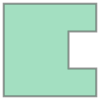

In [3]:
polygon = Polygon(polygon_points)
polygon

In [4]:
polygon.area

88.0

In [5]:
import numpy as np

In [6]:
points = np.random.rand(150, 2)

In [7]:
points[:5, :]

array([[0.07716173, 0.21086848],
       [0.85870648, 0.5834213 ],
       [0.45157937, 0.13945154],
       [0.97564823, 0.64031731],
       [0.26488557, 0.47130058]])

In [8]:
points[:5, 0]

array([0.07716173, 0.85870648, 0.45157937, 0.97564823, 0.26488557])

In [9]:
points[:5, 1]

array([0.21086848, 0.5834213 , 0.13945154, 0.64031731, 0.47130058])

In [10]:
import matplotlib.pyplot as plt

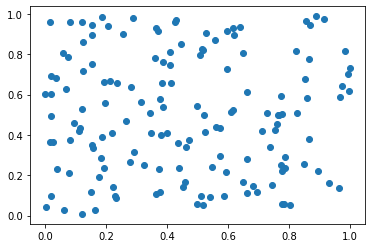

In [11]:
plt.scatter(points[:, 0], points[:, 1])

In [12]:
polygon.minimum_rotated_rectangle.area

100.0

In [13]:
points = np.random.rand(15 * int(polygon.minimum_rotated_rectangle.area), 2)

In [14]:
len(points)

1500

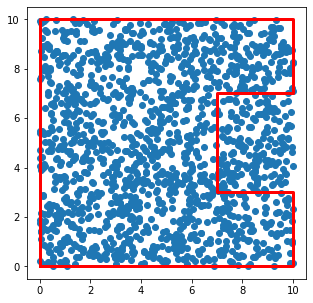

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(points[:, 0] * 10, points[:, 1] * 10)
ax.plot(np.array(polygon_points)[:, 0], 
         np.array(polygon_points)[:, 1],
         lw=3, color='red')

In [16]:
points * 10

array([[3.62723144, 7.21437556],
       [7.47426086, 3.54006492],
       [2.62201496, 3.43713783],
       ...,
       [1.52462786, 8.77368566],
       [8.39473815, 7.89733494],
       [0.46439305, 5.63154238]])

In [17]:
points = points * 10

In [18]:
from shapely.geometry import MultiPoint

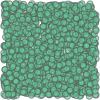

In [19]:
MultiPoint(points)

In [20]:
multi_points = MultiPoint(points)

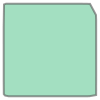

In [21]:
multi_points.convex_hull

In [22]:
print(multi_points.convex_hull)

POLYGON ((8.216613776182879 0.0006368053460070744, 0.519987837271273 0.006563556143250882, 0.1485989241722463 0.08101508677693992, 0.01268461717019109 0.2319518671282905, 0.002728932339406409 1.74024199622077, 0.001382212321345833 7.575716549396809, 0.03405927786457652 9.915358495496848, 0.2596863417509854 9.997512812697536, 8.45850697260477 9.991799555422352, 9.318282046061167 9.9802666552538, 9.963784536613703 8.775074317385855, 9.983216715607568 8.269996511201791, 9.985887959349704 2.340203422477466, 9.980679328462267 0.1369654481805382, 9.250268939652853 0.008396423737777603, 8.216613776182879 0.0006368053460070744))


In [23]:
multi_points.convex_hull.exterior.coords[:]

[(8.216613776182879, 0.0006368053460070744),
 (0.519987837271273, 0.0065635561432508815),
 (0.1485989241722463, 0.08101508677693992),
 (0.012684617170191093, 0.23195186712829052),
 (0.002728932339406409, 1.7402419962207705),
 (0.0013822123213458326, 7.575716549396809),
 (0.03405927786457652, 9.915358495496848),
 (0.25968634175098537, 9.997512812697536),
 (8.45850697260477, 9.991799555422352),
 (9.318282046061167, 9.9802666552538),
 (9.963784536613703, 8.775074317385855),
 (9.983216715607568, 8.269996511201791),
 (9.985887959349704, 2.340203422477466),
 (9.980679328462267, 0.13696544818053824),
 (9.250268939652853, 0.008396423737777603),
 (8.216613776182879, 0.0006368053460070744)]

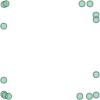

In [24]:
multi_points.intersection(multi_points.convex_hull.exterior)

In [25]:
points_in_polygon = multi_points.intersection(polygon)

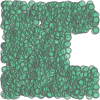

In [26]:
points_in_polygon

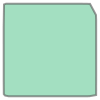

In [27]:
points_in_polygon.convex_hull

## AlphaShape ou ConcaveHull

In [28]:
from shapely.ops import cascaded_union, polygonize
from shapely import geometry
from scipy.spatial import Delaunay
import math

In [29]:
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull

    coords = np.array([point.coords[0] for point in points])
    tri = Delaunay(coords)
    triangles = coords[tri.vertices]
    a = ((triangles[:,0,0] - triangles[:,1,0]) ** 2 + (triangles[:,0,1] - triangles[:,1,1]) ** 2) ** 0.5
    b = ((triangles[:,1,0] - triangles[:,2,0]) ** 2 + (triangles[:,1,1] - triangles[:,2,1]) ** 2) ** 0.5
    c = ((triangles[:,2,0] - triangles[:,0,0]) ** 2 + (triangles[:,2,1] - triangles[:,0,1]) ** 2) ** 0.5
    s = ( a + b + c ) / 2.0
    areas = (s*(s-a)*(s-b)*(s-c)) ** 0.5
    circums = a * b * c / (4.0 * areas)
    filtered = triangles[circums < (1.0 / alpha)]
    edge1 = filtered[:,(0,1)]
    edge2 = filtered[:,(1,2)]
    edge3 = filtered[:,(2,0)]
    edge_points = np.unique(np.concatenate((edge1,edge2,edge3)), axis = 0).tolist()
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    
#     print(triangles)
    print(list(map(lambda x: x.buffer(-0.20).intersection(points).type == 'MultiPoint', triangles)))
    return cascaded_union(list(filter(lambda x: x.buffer(-0.20).intersection(points).type == 'MultiPoint', triangles)))
#     return triangles

In [30]:
concave_hull = alpha_shape(points_in_polygon, alpha=1.5)

[True, False, False]


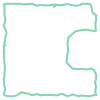

In [31]:
concave_hull.exterior

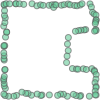

In [32]:
MultiPoint(concave_hull.exterior.coords[:])

In [33]:
concave_hull.exterior.length

45.78013351773885

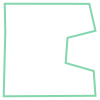

In [34]:
concave_hull.exterior.simplify(0.5)

## Parametrização de uma Solução Candidata (Genoma)

* Pontos da borda em sequência
* Cada ponto pode ou não estar na solução final (gene)
* Cada ponto pode se deslocar em X e Y, restrito por um raio limite máximo (potencial mutação)
    * Esse limite de deslocamento máximo é dado pelo potencial de proximidade com o vértice ideal

> Restrições

* Necessário no mínimo 3 pontos
* Necessário que a geometria seja válida topologicamente (is_valid)
* Necessário que a área da geometria não varie mais que 5% da geometria AlphaShape


In [35]:
pontos_borda = concave_hull.exterior.coords[:]

In [36]:
len(pontos_borda)

108

In [37]:
np.random.rand(1, len(pontos_borda)) > 0.98

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False]])

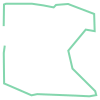

In [38]:
LineString(np.array(pontos_borda)[(np.random.rand(1, len(pontos_borda)) > 0.75)[0]])

## Calculando a área do mínimo retangulo orientado a cada 3, 5 e 7 pontos

In [232]:
a_ponto_borda = np.array(pontos_borda)
# a_ponto_borda = np.arange(0, 99)

In [233]:
a_ponto_borda = np.concatenate([a_ponto_borda[-10:], a_ponto_borda, a_ponto_borda[:10]])

In [266]:
area = np.array([])

for i in np.arange(0 + 10, 99 + 10):
    area = np.append(area, 
#               Polygon(a_ponto_borda[i-10:i+10+1]).area +
#               Polygon(a_ponto_borda[i-8:i+8+1]).area + 
              Polygon(a_ponto_borda[i-3:i+4]).area / LineString(a_ponto_borda[i-3:i+4]).length + \
              Polygon(a_ponto_borda[i-2:i+3]).area / LineString(a_ponto_borda[i-2:i+3]).length+ \
              Polygon(a_ponto_borda[i-1:i+2]).area / LineString(a_ponto_borda[i-1:i+2]).length)

In [267]:
area = np.interp(area, (area.min(), area.max()), (0., 1.))

In [268]:
# a_ponto_borda[3:99+3][area > 0.8]

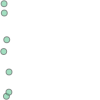

In [269]:
(MultiPoint(a_ponto_borda[27:34]))

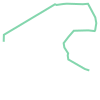

In [270]:
LineString(a_ponto_borda[3:99+3][area > 0.5])

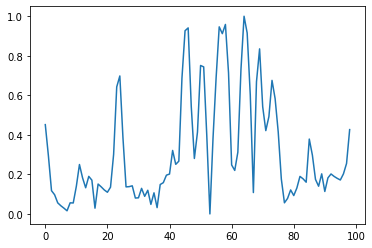

In [271]:
plt.plot(area)

In [272]:
# np.array(list(map(lambda x: x, pontos_borda.index)))
# np.indices(pontos_borda)
for i in np.arange(len(pontos_borda)):
    pontos_borda[i-3:i+3]

In [273]:
len(np.roll(pontos_borda, -1, axis=0))
# pontos_borda

99

In [274]:
a_ponto_borda = np.array(pontos_borda)

array([[1.43750350e-01, 2.76694372e-01],
       [8.28745695e-03, 4.10281171e-01],
       [1.05243859e-01, 1.33707700e+00],
       [3.98711555e-02, 1.42323256e+00],
       [2.64331564e-02, 1.80087256e+00],
       [4.82378329e-02, 1.98672778e+00],
       [4.87611059e-02, 2.11601085e+00],
       [8.13311999e-02, 2.82339580e+00],
       [5.69251945e-02, 2.86673273e+00],
       [9.85432469e-02, 3.23308790e+00],
       [1.02270273e-01, 3.32717917e+00],
       [1.82597412e-01, 3.49689018e+00],
       [2.39689695e-01, 4.27834562e+00],
       [1.30864845e-02, 4.53864992e+00],
       [1.20307591e-02, 5.20755862e+00],
       [8.78728129e-02, 5.72873270e+00],
       [8.10649717e-02, 5.88877034e+00],
       [1.00104754e-01, 6.62845723e+00],
       [1.81021683e-01, 6.76330742e+00],
       [1.85417338e-01, 7.42295069e+00],
       [1.11370922e-02, 8.09223465e+00],
       [1.10441911e-01, 8.47760229e+00],
       [3.04849372e-02, 9.35105087e+00],
       [2.27669821e-02, 9.65610874e+00],
       [9.320152

In [204]:
import pygad as ga

## Parametrização de Objetivo (Pontuação Fitness)

* Minimizar a relação de Quantidade de pontos fora / dentro do polígono (+1)
* Minimizar a Distância Hausdorff entre as borda Alpha-Shape para a borda atual
* Minimizar a Quantidade de vértices pelo comprimento total
* Maximizar o paralelismo entre as arestas (direções unicas em Radianos 0 --> Pi)
* Maximizar o ajuste à grade de uma provável coordenação modular (Minimizar o MMC, considerar uma resolução espacial mínima, 1:1000 20cm)

In [206]:
def fitness_func(solution, solution_id):
    return fitness